In [23]:
import os
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import librosa

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from preprocess import split_data
from evaluate import evaluate_predictions, plot_history
from utils.constants import DATA_DIR, SEED

In [24]:
random.seed(SEED)
np.random.seed(SEED)
sklearn.random.seed(SEED)
tf.random.set_seed(SEED)

In [25]:
## Important Params
SEGMENT_NUM = 5

split_precentages = {
    'train': 0.7,
    'valid': 0.15,
    'test': 0.15
}

In [27]:
## load processed data

# load aggregated data
file_name = f'{SEGMENT_NUM}_data.npz'
file_path = os.path.join(DATA_DIR, 'processed_data')
npzfile = np.load(os.path.join(file_path, file_name))
print(npzfile.files)

X_agg = npzfile['X']
Y_agg = npzfile['Y']


# load mfcc and mel data
file_name = f'{SEGMENT_NUM}_data_parts.npz'
file_path = os.path.join(DATA_DIR, 'processed_data')
npzfile = np.load(os.path.join(file_path, file_name))
print(npzfile.files)

X_mfcc = npzfile['mfcc']
X_mel = npzfile['mel']
Y_mfcc_mel = npzfile['labels']

['X', 'Y']
['labels', 'mfcc', 'mel']


## Preprocess Data

In [28]:
## Split Data
X_agg_train, X_agg_valid, X_agg_test, Y_agg_train, Y_agg_valid, Y_agg_test = split_data(X_agg, Y_agg, split_precentages)
X_mfcc_train, X_mfcc_valid, X_mfcc_test, Y_mfcc_train, Y_mfcc_valid, Y_mfcc_test = split_data(X_mfcc, Y_mfcc_mel, split_precentages)
X_mel_train, X_mel_valid, X_mel_test, _, _, _ = split_data(X_mel, Y_mfcc_mel, split_precentages)

In [29]:
## Scale & Reshape
def scale(X_train, X_valid, X_test):
    maximum = X_train.max()
    X_train = X_train/maximum
    X_valid = X_valid/maximum
    X_test = X_test/maximum

    return X_train.astype(np.float32), X_valid.astype(np.float32), X_test.astype(np.float32)

X_agg_train, X_agg_valid, X_agg_test = scale(X_agg_train, X_agg_valid, X_agg_test)
X_mfcc_train, X_mfcc_valid, X_mfcc_test = scale(X_mfcc_train, X_mfcc_valid, X_mfcc_test)
X_mel_train, X_mel_valid, X_mel_test = scale(X_mel_train, X_mel_valid, X_mel_test)

In [30]:
# we also have to reshape the spectograms for the CNN
X_mel_train = X_mel_train.reshape((X_mel_train.shape[0], X_mel_train.shape[1], X_mel_train.shape[2], 1))
X_mel_valid = X_mel_valid.reshape((X_mel_valid.shape[0], X_mel_valid.shape[1], X_mel_valid.shape[2], 1))
X_mel_test = X_mel_test.reshape((X_mel_test.shape[0], X_mel_test.shape[1], X_mel_test.shape[2], 1))

In [31]:
genres = 10
genre_list = np.unique(Y_agg)

Y_agg_train = to_categorical(Y_agg_train, genres)
Y_agg_valid = to_categorical(Y_agg_valid, genres)
Y_agg_test = to_categorical(Y_agg_test, genres)

Y_mfcc_train = to_categorical(Y_mfcc_train, genres)
Y_mfcc_valid = to_categorical(Y_mfcc_valid, genres)
Y_mfcc_test = to_categorical(Y_mfcc_test, genres)

In [32]:
def unroll_sequence(X, Y):
    '''
    Creates unrolled data from segmented/sequenced data.
    Y value (genre) is repeated for each segment.
    '''
    
    if X.ndim != 3:
        raise ValueError(f'X only has {X.ndim} dimensions, while 3 were expected')

    row_num = X.shape[0]
    segment_num = X.shape[1]
    feature_num = X.shape[2]
    
    X_unrolled = X.reshape(row_num*segment_num, feature_num)
    Y_unrolled = np.repeat(Y, segment_num, axis=0)

    return X_unrolled, Y_unrolled

# if we are using segmented data, then we have to unroll them for LogReg and RF
X_train_unrolled, Y_train_unrolled = unroll_sequence(X_agg_train, Y_agg_train) 
X_valid_unrolled, Y_valid_unrolled = unroll_sequence(X_agg_valid, Y_agg_valid) 
X_test_unrolled, Y_test_unrolled = unroll_sequence(X_agg_test, Y_agg_test) 

print('X_train_unrolled shape: ', X_train_unrolled.shape)
print('Y_train_unrolled shape: ', Y_train_unrolled.shape)

X_train_unrolled shape:  (699, 37)
Y_train_unrolled shape:  (699, 10)


## Model training

In [33]:
from sklearn.linear_model import LogisticRegression

MAX_ITER = 10_000

logreg_model = LogisticRegression(max_iter=MAX_ITER, verbose=0)
logreg_model.fit(X_train_unrolled, Y_train_unrolled.argmax(axis=1))

LogisticRegression(max_iter=10000)

In [34]:
from sklearn.ensemble import RandomForestClassifier

N_ESTIMATORS = 200
MAX_DEPTH = 8

rf = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
rf.fit(X_train_unrolled, Y_train_unrolled.argmax(axis=1))

RandomForestClassifier(max_depth=8, n_estimators=200)

In [53]:
## general for all other models

BATCH_SIZE = 32

es = EarlyStopping(
    patience=10, 
    restore_best_weights=True, 
    start_from_epoch=5)
callbacks = [es]

In [54]:
## LSTM
LSTM_model = Sequential([
    LSTM(128, dropout=0.0, recurrent_dropout=0.0, return_sequences=True),
    BatchNormalization(),
    LSTM(64, dropout=0.0, recurrent_dropout=0.0),
    BatchNormalization(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(10, activation="softmax")
])

LSTM_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.2940 - loss: 2.0002 - val_accuracy: 0.1375 - val_loss: 2.2305
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step - accuracy: 0.4078 - loss: 1.6297 - val_accuracy: 0.1802 - val_loss: 2.1618
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.4580 - loss: 1.5319 - val_accuracy: 0.2443 - val_loss: 2.0017
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.4726 - loss: 1.4494 - val_accuracy: 0.3017 - val_loss: 1.8141
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.5133 - loss: 1.3825 - val_accuracy: 0.3351 - val_loss: 1.8386
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.5238 - loss: 1.3467 - val_accuracy: 0.3271 - val_loss: 1.8393
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.5422 - loss: 1.3013 - val_accuracy: 0.4005 - val_loss: 1.6677
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.5555 - loss: 1

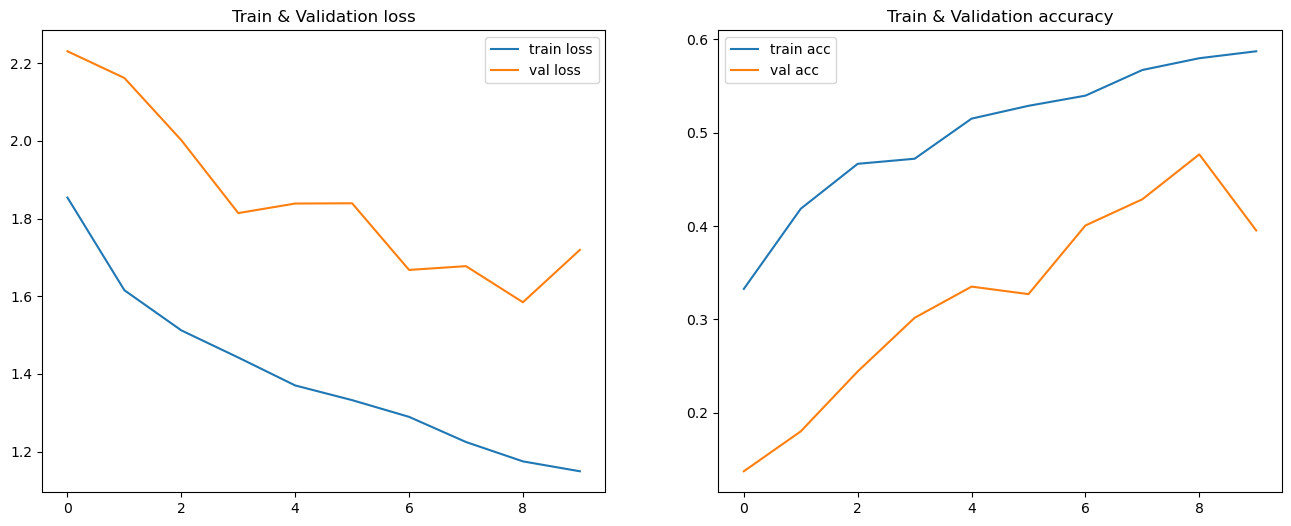

In [57]:
EPOCHS = 10

history = LSTM_model.fit(
    X_mfcc_train, Y_mfcc_train.argmax(axis=1).reshape(-1,1), 
    validation_data=(X_mfcc_valid, Y_mfcc_valid.argmax(axis=1).reshape(-1,1)),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

plot_history(history)

In [58]:
# CNN model
CNN_model = Sequential([
    Conv2D(8, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.1563 - loss: 2.2443 - val_accuracy: 0.2630 - val_loss: 1.8626
Epoch 2/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3154 - loss: 1.8574 - val_accuracy: 0.3578 - val_loss: 1.6299
Epoch 3/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3861 - loss: 1.6589 - val_accuracy: 0.4566 - val_loss: 1.4510
Epoch 4/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4252 - loss: 1.5392 - val_accuracy: 0.4900 - val_loss: 1.3335
Epoch 5/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4955 - loss: 1.4278 - val_accuracy: 0.5407 - val_loss: 1.2209
Epoch 6/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5146 - loss: 1.3178 - val_accuracy: 0.5247 - val_loss: 1.2114
Epoch 7/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5432 - loss: 1.2396 - val_accuracy: 0.5648 - val_loss: 1.1462
Epoch 8/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5626 - loss: 1.2062 - 

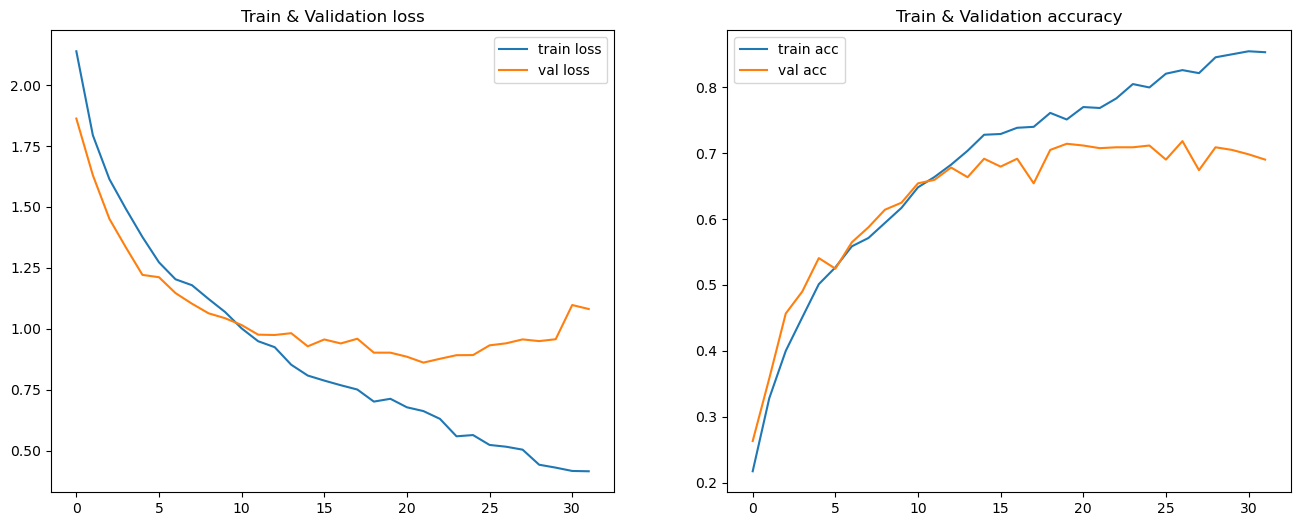

In [59]:
EPOCHS = 200

history = CNN_model.fit(
    X_mel_train, Y_mfcc_train.argmax(axis=1).reshape(-1,1),
    validation_data=(X_mel_valid, Y_mfcc_valid.argmax(axis=1).reshape(-1,1)),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

plot_history(history)

## Evaluation

In [85]:
Y_agg_true = Y_agg_test.argmax(axis=1)
Y_agg_true_unrolled = Y_test_unrolled.argmax(axis=1)
Y_mfcc_true = Y_mfcc_test.argmax(axis=1)

In [61]:
# predictions
Y_pred_logreg = logreg_model.predict(X_test_unrolled)
Y_pred_rf = rf.predict(X_test_unrolled)
Y_pred_lstm = LSTM_model.predict(X_mfcc_test).argmax(axis=1)
Y_pred_cnn = CNN_model.predict(X_mel_test).argmax(axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [62]:
# 1.baseline - predicting the most common class in the test set
labels, counts = np.unique(Y_true, return_counts=True)
baseline_acc = (counts.sum() / counts.max()) / 100
print(f'1.Baseline: predicting the most common label, achieved accuracy: {baseline_acc:0.2%}')

# 2.baseline - predicting randomly
print('2.Baseline: random prediction')
random_pred_num = 10
for i in range(random_pred_num):
    random_pred = np.random.randint(0, 10, size=Y_true.shape[0])
    print(f'\t{i}.accuracy: {accuracy_score(Y_true, random_pred):0.2%}')

1.Baseline: predicting the most common label, achieved accuracy: 7.95%
2.Baseline: random prediction
	0.accuracy: 7.95%
	1.accuracy: 15.23%
	2.accuracy: 9.93%
	3.accuracy: 10.60%
	4.accuracy: 9.27%
	5.accuracy: 7.95%
	6.accuracy: 9.93%
	7.accuracy: 10.60%
	8.accuracy: 11.92%
	9.accuracy: 10.60%


In [73]:

def evaluate_predictions(Y_true, Y_pred, genre_list):
    '''Evaluates predictions based on many metrics'''

    print(f'Accuracy: {accuracy_score(Y_true, Y_pred):0.2%}')
    print(f'Precision: {precision_score(Y_true, Y_pred, average="macro"):0.2%}')
    print(f'Recall: {recall_score(Y_true, Y_pred, average="macro"):0.2%}')
    print(f'F1: {f1_score(Y_true, Y_pred, average="macro")}')
    
    conf = confusion_matrix(Y_true, Y_pred)
    fig, ax = plt.subplots()
    ax.matshow(conf)
    
    genres = len(genre_list)
    ax.set_xticks(np.arange(genres), labels=genre_list)
    ax.set_yticks(np.arange(genres), labels=genre_list)
    
    for i in range(genres):
        for j in range(genres):
            text = ax.text(j, i, conf[i, j], ha="center", va="center", color="w", size=8)
    
    plt.title('Confusion Matrix for Classes')
    plt.show() 
    return fig 

----------LOGREG----------
Accuracy: 21.85%
Precision: 8.26%
Recall: 21.03%
F1: 0.11537766659717881


/home/dani/miniconda3/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


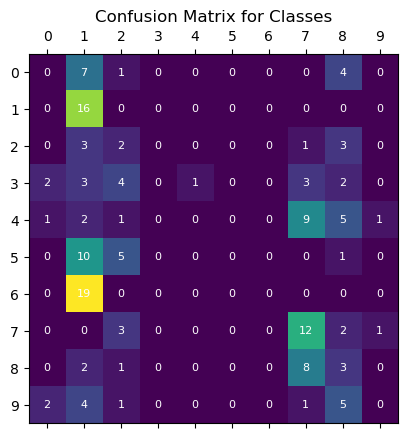

In [75]:
print('----------LOGREG----------')
fig = evaluate_predictions(Y_agg_true_unrolled, Y_pred_logreg, genre_list)

----------RANDOM_FOREST----------
Accuracy: 65.56%
Precision: 63.66%
Recall: 63.12%
F1: 0.6165136356472963


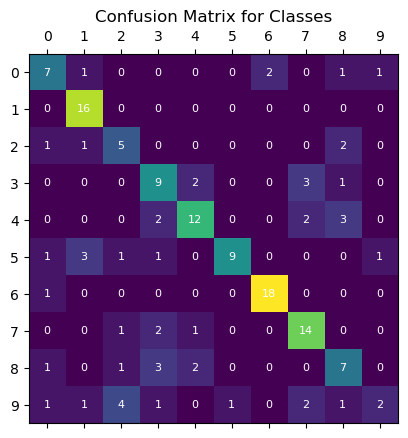

In [76]:
print('----------RANDOM_FOREST----------')
fig = evaluate_predictions(Y_agg_true_unrolled, Y_pred_rf, genre_list)

----------LSTM----------
Accuracy: 47.33%
Precision: 46.27%
Recall: 45.19%
F1: 0.44437393434761246


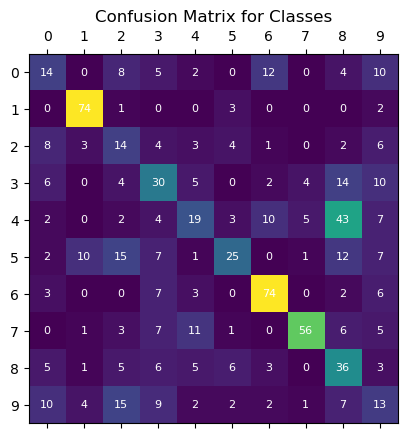

In [86]:
print('----------LSTM----------')
fig = evaluate_predictions(Y_mfcc_true, Y_pred_lstm, genre_list)

----------CNN----------
Accuracy: 72.40%
Precision: 71.01%
Recall: 71.70%
F1: 0.7041752495522774


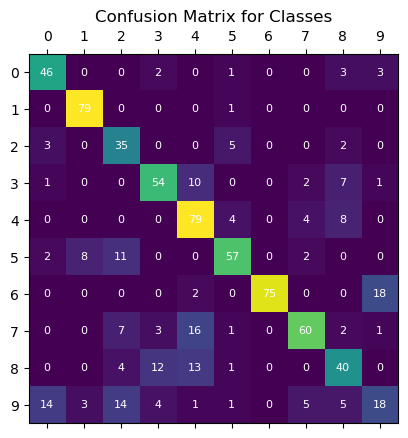

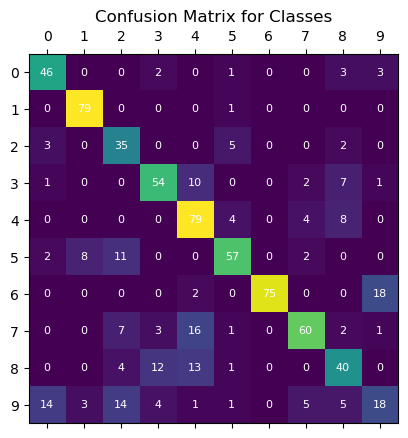

In [87]:
print('----------CNN----------')
evaluate_predictions(Y_mfcc_true, Y_pred_cnn, genre_list)